# Сравнение функций правдоподобия для метода статистической деконволюции

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

In [2]:
from modules_reloader import reloader
from modules import randomized_ir, utils, plots

relmod = reloader(randomized_ir, utils, plots)

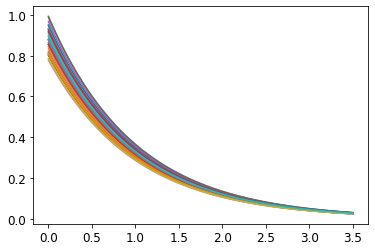

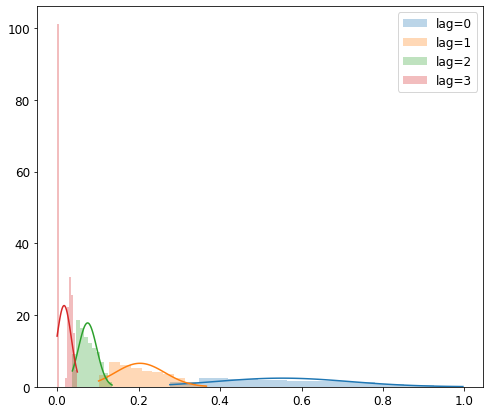

In [3]:
from random import random

L_true = 3.5
ir_x = np.linspace(0, L_true, int(L_true * 100))
ir_y = np.exp(- ir_x)
rir = randomized_ir.RandomizedIr(ir_x, ir_y, factor=lambda: 0.75 + random() * 0.25)
rir.plot_realizations(30)

L = rir.L
N = 10
rireff = randomized_ir.RandomizedIrEffect(rir, N, samplesize=10 ** 5)
rireff.plot_samples()

## Сравнение наивного Монте-Карло сэмплирования и сэмплирования многомерной нормальной аппроксимации

In [4]:
S_sample_size = 100000

In [5]:
n_vec_mean = 15
n_vec = utils.generate_poissonian_ns(n_vec_mean, N)
s_vec = rir.convolve_with_n_vec(n_vec)
n_vec_estimation = rireff.estimate_n_vec(s_vec)

In [6]:
S_sample_true = rireff.sample_S_vec(n_vec_estimation, n_samples=S_sample_size, progress=True)

mu_true = np.mean(S_sample_true, axis=1)
Sigma_true = np.cov(S_sample_true)

mu_true = utils.slice_edge_effects(mu_true, L, N)
Sigma_true = Sigma_true[L:N, L:N]

In [7]:
mvn_approx = rireff.get_multivariate_normal_S_vec(n_vec_estimation)
mu_approx = mvn_approx.mean
Sigma_approx = mvn_approx.cov

Text(0.5, 1.0, 'Mean vector comparison')

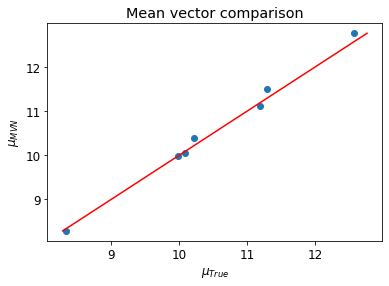

In [8]:
fig, ax = plt.subplots()

min_mu = min(mu_approx.min(), mu_true.min())
max_mu = max(mu_approx.max(), mu_true.max())

ax.scatter(mu_true, mu_approx)
ax.plot([min_mu, max_mu], [min_mu, max_mu], 'r')
ax.set_xlabel('$\\mu_{{True}}$')
ax.set_ylabel('$\\mu_{{MVN}}$')
ax.set_title('Mean vector comparison')

In [9]:
def sigmas_and_corr_mat_from_cov_mat(Sigma):
    sigmas = np.sqrt(np.diagonal(Sigma))
    corr_mat = Sigma
    for i in range(corr_mat.shape[0]):
        for j in range(corr_mat.shape[1]):
            corr_mat[i, j] /= sigmas[i] * sigmas[j]
    return sigmas, corr_mat

In [10]:
sigma_approx, corr_mat_approx = sigmas_and_corr_mat_from_cov_mat(Sigma_approx)
sigma_true, corr_mat_true = sigmas_and_corr_mat_from_cov_mat(Sigma_true)

Text(0.5, 1.0, 'Standard deviation vector comparison')

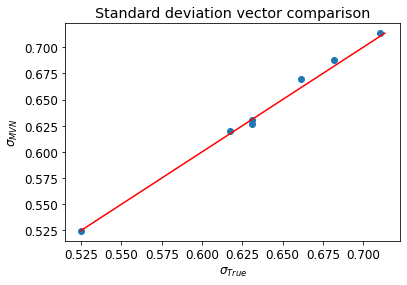

In [11]:
fig, ax = plt.subplots()

min_sgm = min(sigma_approx.min(), sigma_true.min())
max_sgm = max(sigma_approx.max(), sigma_true.max())

ax.scatter(sigma_true, sigma_approx)
ax.plot([min_sgm, max_sgm], [min_sgm, max_sgm], 'r')
ax.set_xlabel('$\\sigma_{{True}}$')
ax.set_ylabel('$\\sigma_{{MVN}}$')
ax.set_title('Standard deviation vector comparison')

In [12]:
def print_corr_mat(m):
    for row in m:
        print('\t'.join(f'{i:.3f}' for i in row))

corr_mat_residual = corr_mat_approx - corr_mat_true
print(f"Max difference in MC and MVN approx correlation coeff: {np.abs(corr_mat_residual).max():.4f}")
print()
print(f"Correlation matrices delta:")
print_corr_mat(corr_mat_approx - corr_mat_true)

Max difference in MC and MVN approx correlation coeff: 0.0075

Correlation matrices delta:
0.000	0.002	0.004	0.005	-0.000	0.000	-0.001
0.002	0.000	0.004	0.005	0.002	0.000	0.005
0.004	0.004	-0.000	-0.001	0.001	0.000	0.003
0.005	0.005	-0.001	-0.000	0.001	-0.001	-0.002
-0.000	0.002	0.001	0.001	0.000	0.003	-0.008
0.000	0.000	0.000	-0.001	0.003	-0.000	-0.004
-0.001	0.005	0.003	-0.002	-0.008	-0.004	0.000


И средние, и дисперсии, и коэффициенты корреляции воспроизводятся хорошо!

## Прямое сравнение likelihood, определённых разными методами

In [22]:
n_vec_mean = 20
n_vec = utils.generate_poissonian_ns(n_vec_mean, N)
s_vec = rir.convolve_with_n_vec(n_vec)

In [23]:
rng = np.random.default_rng()

# creating evaluation points grouped somwhere around maximum likelihood point
N_evaluation_points = 10
spread_from_estimation = 0.5  # from n_vec_estimation, in n units
evaluation_points = np.tile(n_vec, (N_evaluation_points, 1)) + rng.normal(scale=spread_from_estimation, size=(N_evaluation_points, N))

In [24]:
@utils.timer(args_formatter=lambda l, p, n: n + f', {p.shape[0]} points')
def evaluate_loglike(loglike, points, name):
    results = []
    for p in tqdm(points):
        results.append(np.exp(loglike(p)))  # converting loglike back to regular PDF for comparison
    return np.array(results)

In [25]:
mc_loglike = rireff.get_loglikelihood_monte_carlo(s_vec)
mvn_loglike = rireff.get_loglikelihood_mvn(s_vec)

# print(f"MC loglike = {mc_loglike(n_vec_estimation, progress=True)}")
# print(f"MVN loglike{mvn_loglike(n_vec_estimation)}")

In [26]:
mvn_results = evaluate_loglike(mvn_loglike, evaluation_points, 'Multivariate normal likelihood')
np.savetxt('../precomputed/mvn_results.txt', mvn_results)

100%|██████████| 10/10 [00:00<00:00, 3171.74it/s]

evaluate_loglike(Multivariate normal likelihood, 10 points) took 0.005 seconds to complete.



In [27]:
from functools import partial

mc_results = evaluate_loglike(partial(mc_loglike, progress=True), evaluation_points, 'Naive MC likelihood')
np.savetxt('../precomputed/mc_results.txt', mc_results)

  0%|          | 0/10 [00:00<?, ?it/s]


 10%|█         | 1/10 [02:52<25:53, 172.60s/it]There's 991 points per bin -- seems enough; median is 2.0 among nonzero bins



 20%|██        | 2/10 [05:44<22:59, 172.41s/it]There's 1120 points per bin -- seems enough; median is 2.0 among nonzero bins



/home/njvh/Documents/Science/sphere/thesis/modules/randomized_ir.py:305: RuntimeWarning: divide by zero encountered in log
  return np.log(ndepdf(s_sample, center_s_vec, bins=10, check_bin_count=True))
 30%|███       | 3/10 [08:42<20:18, 174.11s/it]There's 918 points per bin -- seems enough; median is 2.0 among nonzero bins



 40%|████      | 4/10 [11:39<17:28, 174.82s/it]There's 1207 points per bin -- seems enough; median is 2.0 among nonzero bins



 50%|█████     | 5/10 [14:34<14:34, 174.88s/it]There's 1118 points per bin -- seems enough; median is 2.0 among nonzero bins



 60%|██████    | 6/10 [17:31<11:42, 175.62s/it]There's 957 points per bin -- seems enough; median is 2.0 among nonzero bins



 70%|███████   | 7/10 [20:27<08:47, 175.86s/it]There's 1093 points per bin -- seems enough; median is 2.0 among nonzero bins



 80%|████████  | 8/10 [23:20<05:49, 174.75s/it]There's 1157 points per bin -- seems enough; median is 2.0 among nonzero bins



 90%|█████████ | 9/10 [26:12<02:54, 174.05s/it]There's 952 points per bin -- seems enough; median is 2.0 among nonzero bins



100%|██████████| 10/10 [29:02<00:00, 174.25s/it]There's 1113 points per bin -- seems enough; median is 2.0 among nonzero bins


evaluate_loglike(Naive MC likelihood, 10 points) took 1742.478 seconds to complete.



In [28]:
mvn_results = np.loadtxt('../precomputed/mvn_results.txt')
mc_results = np.loadtxt('../precomputed/mc_results.txt')

In [29]:
average = 0.5 * (mvn_results + mc_results)
residual = np.abs(mvn_results - mc_results)

print(f'values around {np.mean(average)}')
print(f'residual = {np.mean(residual)} +/- {np.std(residual)}')
print(f'relative = {100 * np.mean(residual / average):.2f} +/- {100 * np.std(residual / average):.2f}%')

values around 1.7676458613046375e-05
residual = 2.603334747242887e-05 +/- 2.4458087195635303e-05
relative = 176.29 +/- 30.34%


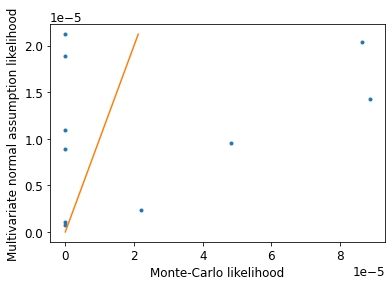

In [30]:
min_l = min(mvn_results.min(), mc_results.min())
max_l = min(mvn_results.max(), mc_results.max())
rng_l = np.linspace(min_l, max_l)

plt.plot(mc_results, mvn_results, '.')
plt.plot(rng_l, rng_l)

plt.xlabel('Monte-Carlo likelihood')
plt.ylabel('Multivariate normal assumption likelihood')
# plt.yscale('log')
# plt.xscale('log')
plt.show()

Резюме: прямое сравнение распределений не даёт особого результата из-за флуктуаций многомерной гистограммы для оценки PDF

**UPD: всё почему-то сломалось в naive MC likelihood, а было вроде неплохо :(**

# Оценка применимости многомерного нормального приближения

In [21]:
def generate_S_sample(n_vec_mean):
    N = 50
    n_vec = utils.generate_poissonian_ns(n_vec_mean, N)
    s_vec = rir.convolve_with_n_vec(n_vec)
    n_vec_estimation = stats.estimate_n_vec(s_vec)
    S_sample = stats.sample_S_vec(n_vec_estimation, 50000, progress=True)
    return S_sample

In [8]:
n_vec_means = [1, 2, 4, 10]
S_samples = [generate_S_sample(nvm) for nvm in n_vec_means]

## Частные распределения

In [15]:
save_plots = False

(<Figure size 504x576 with 12 Axes>,
 array([[<AxesSubplot:ylabel='$\\bar{n} = 1$'>, <AxesSubplot:>,
         <AxesSubplot:>],
        [<AxesSubplot:ylabel='$\\bar{n} = 2$'>, <AxesSubplot:>,
         <AxesSubplot:>],
        [<AxesSubplot:ylabel='$\\bar{n} = 4$'>, <AxesSubplot:>,
         <AxesSubplot:>],
        [<AxesSubplot:xlabel='$S_{best}$', ylabel='$\\bar{n} = 10$'>,
         <AxesSubplot:xlabel='$S_{median}$'>,
         <AxesSubplot:xlabel='$S_{worst}$'>]], dtype=object))

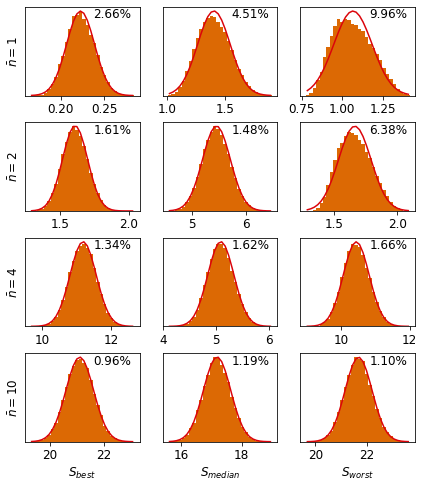

In [16]:
plots.plot_S_j_marginal_normality_assessment(S_samples, n_vec_means, stats.L, filename='S-j-normality-assessment.pdf' is save_plots else None)

## Попарные корреляции

In [13]:
relmod()

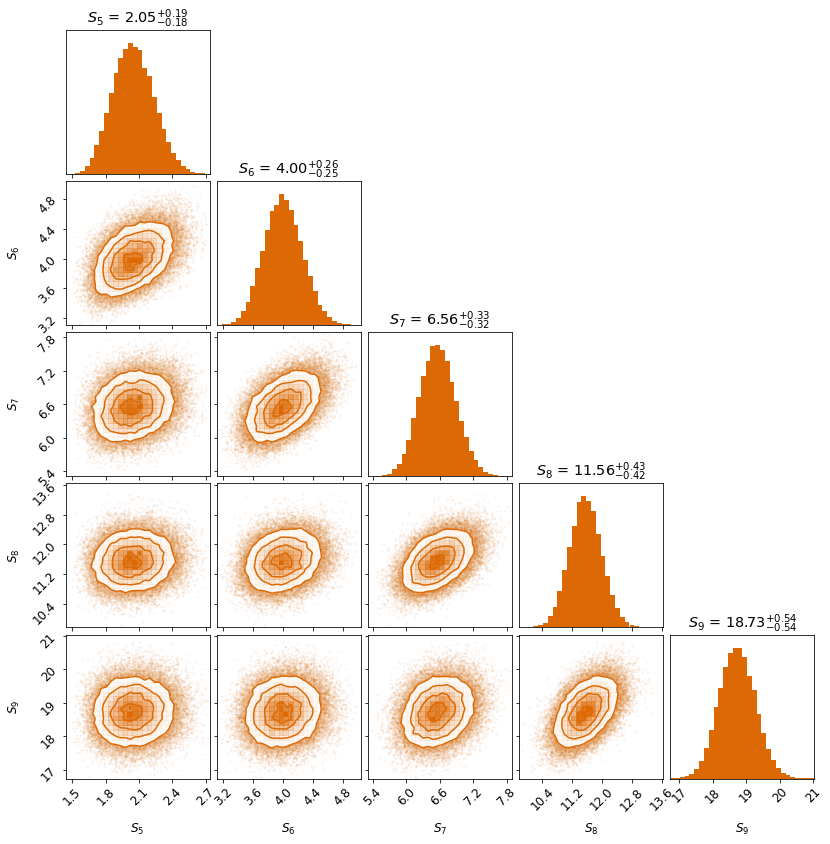

In [14]:
f = plots.plot_S_j_pairwise_normality_assessment(S_samples[-1], stats.L, filename='S-j-pairwise-normality-assessment.pdf' is save_plots else None)